In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from helper import *
%matplotlib inline

In [101]:
def get_regions_simulation(region):
    regions_simulation = {}
    for index, row in region.iterrows():
        regions_simulation[row["region_label"]] = simulate_region(row["density"], row["population"], min_pop=100)
    return regions_simulation

In [7]:
def visualize_region(df, region_name):
    ts = df[region_name]
    ts.index = (ts.index)
    ax = ts.cumsum().plot()
    ax.set_title(region_name)
    ax.set_ylabel("CDF")

In [93]:
def plot_cdfs(data_list, title, labels, lines):
    ax = plt.figure(figsize=(10,6))
    min_axis = []
    max_axis = []
    for i, data in enumerate(data_list):
        data_sum = float(data.sum())
        data_mean = data_sum/len(data)
        cdf = data.cumsum(0)/data_sum
        ccdf = 1-cdf
        plt.plot(data,cdf, lines[i], label=labels[i], markersize=1.5, linewidth=0.5)
        min_axis.append(np.partition(np.unique(data), 1)[1]/2)
        max_axis.append(data[-1])
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(loc="upper left")
    plt.xlim([min(min_axis), max(max_axis)])
    plt.ylim([0,5])
    plt.ylabel('CDF')
    plt.title(title)
    plt.grid(True, which='major', color='0.65', linestyle='--')
    #plt.figtext(.7, .6, "mean = %2.f" % data_mean, backgroundcolor='w')
    #plt.figtext(.7, .5, "sum = %d" % data_sum, backgroundcolor='w')
    plt.figtext(.5, .2, "author: ricardosilveira@poli.ufrj.br", fontsize=8, fontstyle="italic", backgroundcolor='w')
    return ax

In [76]:
def top5_infected_regions(country_name, cases):
    top5_infected_regions = cases.sum().sort_values(ascending=False).head(5).index.get_values()
    ax = cases.sum().sort_values(ascending=True).plot.barh(figsize=(9,6), title="%s - Infected regions" % country_name.replace("_", " ").title())
    dummy = ax.set_xlabel("Total cases")
    ax.grid(True)
    return top5_infected_regions

In [120]:
def plot_sim_for_regions(country_name, regions, lines, filename):
    data_list = []
    for region_label in regions:
        data_list.append(regions_simulation[country_name][region_label])
    title = "%s - Population Distribution" % country_name.replace("_", " ").title()
    plot_cdfs(data_list, title, regions, lines, filename)

## Loading region information for each country

In [3]:
regions_df = pd.read_csv('regions.csv')
br_regions = regions_df[regions_df["country"]=="brazil"]
it_regions = regions_df[regions_df["country"]=="italy"]
sk_regions = regions_df[regions_df["country"]=="south_korea"]

In [102]:
regions_simulation = {}
regions_simulation["brazil"] = get_regions_simulation(br_regions)
regions_simulation["italy"] = get_regions_simulation(it_regions)
regions_simulation["south_korea"] = get_regions_simulation(sk_regions)

## Loading cases and deaths for each country

In [72]:
br_cases, br_deaths = get_data('brazil_cases_by_regions.csv')
it_cases, it_deaths = get_data('italy_cases_by_regions.csv')
sk_cases, sk_deaths = get_data('south_korea_cases_by_regions.csv')

## Most infected regions

### South Korea

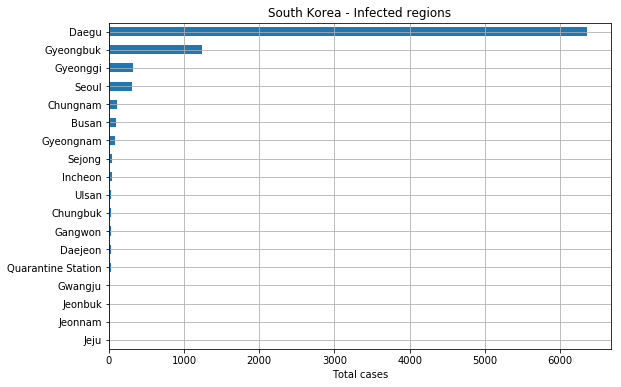

In [77]:
sk_top5 = top5_infected_regions("south_korea", sk_cases)

### Italy

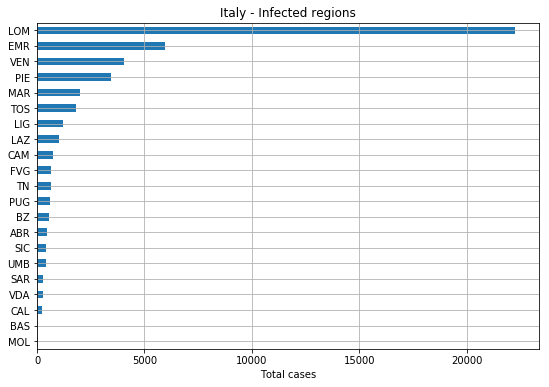

In [104]:
it_top5 = top5_infected_regions("italy", it_cases)

### Brazil

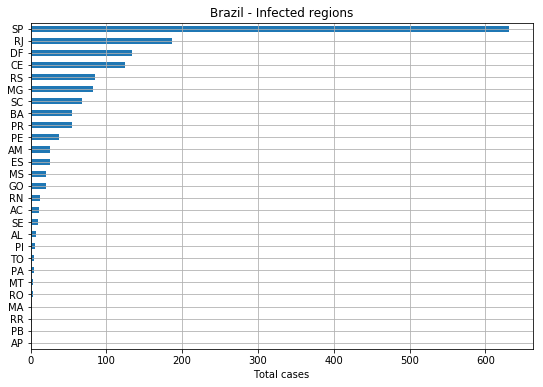

In [79]:
br_top5 = top5_infected_regions("brazil", br_cases)

## Simulation: Population distribution across each region

### South Korea

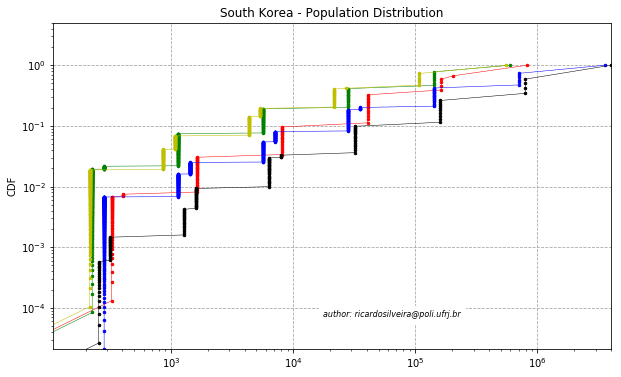

In [121]:
plot_sim_for_regions("south_korea", sk_top5, ["ro-", "go-", "bo-", "ko-", "yo-"], "south_korea_simulation.png")

### Italy

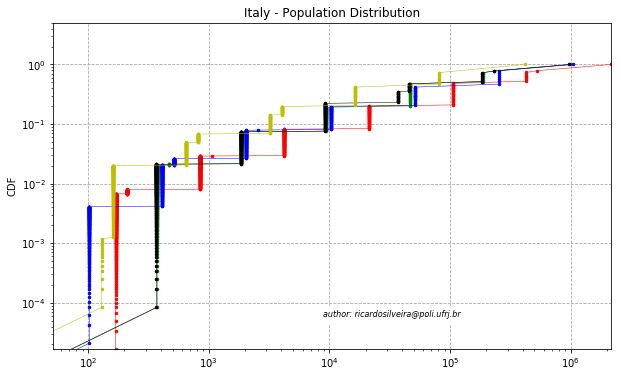

In [122]:
plot_sim_for_regions("italy", it_top5, ["ro-", "go-", "bo-", "ko-", "yo-"], "italy_simulation.png")

### Brazil

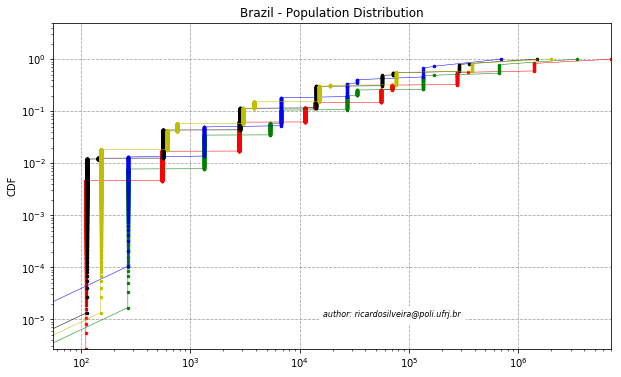

In [123]:
plot_sim_for_regions("brazil", br_top5, ["ro-", "go-", "bo-", "ko-", "yo-"], "brazil_simulation.png")

# In order to better understand the virus, we will use South Korea as our benchmark to answer key questions to allow us to model the epidemic

### 1. what is the propagation rate of the virus?

#### Computing the propagation rate, based on population density

Text(0.5,0,'%')

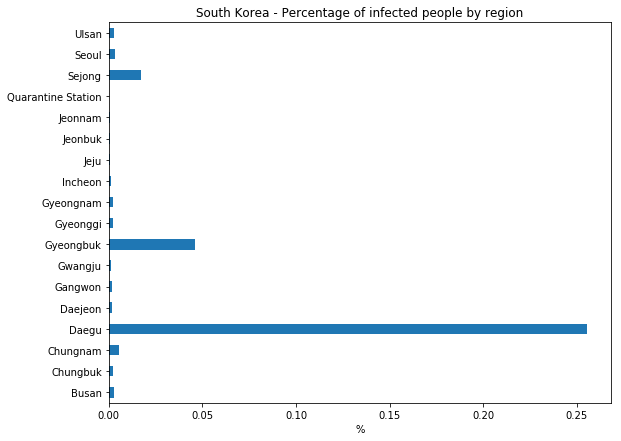

In [8]:
sk_regions.index = sk_regions["region_label"]
propagation = (100*sk_cases.sum()/sk_regions["population"])
ax = propagation.plot.barh(figsize=(9,7))
ax.set_title("South Korea - Percentage of infected people by region")
ax.set_xlabel("%")

Text(0.5,1,'South Korea - Population size')

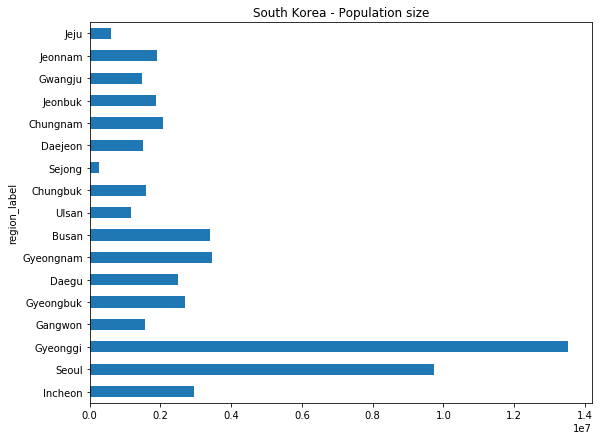

In [9]:
#sk_cases["Daegu"].cumsum().plot()
ax = sk_regions["population"].plot.barh(figsize=(9,7))
ax.set_title("South Korea - Population size")

### 2. what is the mortality rate?

# moratility rate

Text(0.5,0,'%')

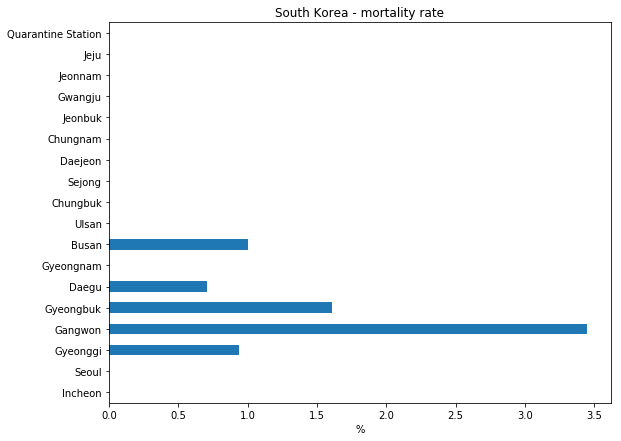

In [13]:
mortality_rate = 100*sk_deaths.sum()/sk_cases.sum()
ax = mortality_rate.plot.barh(figsize=(9,7))
ax.set_title("South Korea - mortality rate")
ax.set_xlabel("%")

### 3. how long does it take on average for the first death case?

## Time between first reported case and first death by region

In [ ]:
# -*- coding: utf-8 -*-
import re
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt


def extract_val(txt):
    deaths = 0
    cases = 0
    txt = str(txt).replace(" ", "").replace("(", " ").replace(")", " ").replace("–", "-")
    try:
        # there are deaths reported
        extract = re.match(r'(?P<cases>.*) (?P<deaths>.*) ', txt)
        cases = int(extract.group('cases'))
        deaths = int(extract.group('deaths'))
    except:
        try:
            # there are deaths reported
            extract = re.match(r' (?P<deaths>.*) (?P<cases>.*)', txt)
            cases = int(extract.group('cases'))
            deaths = int(extract.group('deaths'))
        except:
            try:
                cases = int(float(txt))
            except ValueError:
                # no cases reported
                pass
    return [cases, deaths]
    
def organize_df(df):
    index = pd.DatetimeIndex(df["Date"].unique())
    columns = df.columns
    cases_data = []
    death_data = []
    for index_i, row in df.iterrows():
        cases_row = []
        deaths_row = []
        for col_name in columns:
            if col_name != "Date":
                [cases, deaths] = extract_val(row[col_name])
                cases_row.append(cases)
                deaths_row.append(deaths)
            else:
                cases_row.append(row[col_name])
                deaths_row.append(row[col_name])
        cases_data.append(cases_row)
        death_data.append(deaths_row)
    death_df = pd.DataFrame(data=death_data, columns=columns)
    cases_df = pd.DataFrame(data=cases_data, columns=columns)
    try:
        death_df = death_df.groupby("Date").sum()
        cases_df = cases_df.groupby("Date").sum()
    except:
        pass
    cases_df.index = index
    death_df.index = index
    return cases_df, death_df


def get_data(filepath):
    df = pd.read_csv(filepath).fillna(0)
    return organize_df(df)

def get_time_to_die(cases_ts, deaths_ts):
    cases_ts, deaths_ts
    count_to_death = 0
    for item in deaths_ts:
        count_to_death += 1
        if item > 0:
            break

    if count_to_death == len(deaths_ts):
        count_to_death = 0

    cases_count = 0
    time_to_die = 0
    for item in cases_ts[:count_to_death]:
        cases_count += item
        if item > 0:
            time_to_die += 1
    return time_to_die, cases_count

def gen_pareto(data, total, verbose=False):
    """
    This function creates a distribution following pareto principle, in which 20% of data
    corresponds to 80% of the total. The returned data is a list of values which sum up roughly
    to the value of 'total'
    
    Paremeters
    ----------
     - data (array): list of zeros, this will help to store the values
     - total (int): parameter which tells what the sum of all values should be
     - verbose (bool): if user needs to see the how function is behaving 
    
    Returns
    -------
     - list: same size as 'data' with sum roughty equal to 'total', data is not sorted
    """
    data_size = len(data)
    if verbose:
        print "calling function"
        print "data size:", data_size, "total value:", total
    new_data = []
    if len(data) == 1:
        new_data.append(total)
        return new_data
    if len(data) == 2:
        new_data.append(total*0.2)
        new_data.append(total*0.8)
        return new_data
    if len(data) > 2:
        size_20perc = int(math.floor(data_size*0.8))
        if verbose:
            print "20perc:", size_20perc
        data_20 = data[:size_20perc]
        data_80 = data[size_20perc:]
        new_data = gen_pareto(data_20, total*0.2)
        new_data += gen_pareto(data_80, total*0.8)
        return new_data
    
def simulate_region(density, population, **kwargs):
    """
    This function creates a distribution roughly following a pareto distribution
    we take in a count that a region has very populated areas and very sparse areas as well
    Therefore we should see a percentage of empty areas and a small fraction densily populated
    
    Parameters
    ----------
     - density (int): number of people per squared km
     - population (int): total number of people in the region
     - min_pop (int): smallest number allowed per person in an occupied squared km
     
    Returns
    -------
     - np.array: array of people distributed in the given region parameters
    """
    # we consider the least habitated area with one person per block
    min_pop = kwargs.get("min_pop", 1)
    area = population/density
    # we consider every squared km as a block in the region
    data = np.zeros(area) 
    # now we distribute people across these blocks following a pareto distribution
    ts = pd.Series(gen_pareto(data, population))
    ts = ts.sort_values() # we must sort the values
    sum_min_pop = sum(ts[ts<=min_pop]) # sum of people below min threshold
    ts[ts.size-1] += sum_min_pop #moving these people to the highest occupied area
    ts[ts<=min_pop] = 0 # defining empty space
    return ts.get_values()

def plot_cdf(data, title):
    data_sum = float(data.sum())
    data_mean = data_sum/len(data)
    cdf = data.cumsum(0)/data_sum
    ccdf = 1-cdf
    ax = plt.figure(figsize=(10,6))
    plt.plot(data,cdf,'-o', markersize=2.5, linewidth=0.5)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([np.partition(np.unique(data), 1)[1]/2, data[-1]])
    plt.ylim([0,5])
    plt.ylabel('CDF')
    plt.title(title)
    plt.grid(True, which='major', color='0.65', linestyle='--')
    plt.figtext(.7, .6, "mean = %2.f" % data_mean, backgroundcolor='w')
    plt.figtext(.7, .5, "sum = %d" % data_sum, backgroundcolor='w')
    plt.figtext(.5, .2, "author: ricardosilveira@poli.ufrj.br", fontsize=8, fontstyle="italic", backgroundcolor='w')
    return ax

def plot_cdfs(data_list, title, labels, lines, filename):
    ax = plt.figure(figsize=(10,6))
    min_axis = []
    max_axis = []
    for i, data in enumerate(data_list):
        data_sum = float(data.sum())
        data_mean = data_sum/len(data)
        cdf = data.cumsum(0)/data_sum
        ccdf = 1-cdf
        plt.plot(data,cdf, lines[i], label=labels[i], markersize=2.5, linewidth=0.5)
        min_axis.append(np.partition(np.unique(data), 1)[1]/2)
        max_axis.append(data[-1])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([min(min_axis), max(max_axis)])
    plt.ylim([0,5])
    plt.ylabel('CDF')
    plt.title(title)
    plt.grid(True, which='major', color='0.65', linestyle='--')
    #plt.figtext(.7, .6, "mean = %2.f" % data_mean, backgroundcolor='w')
    #plt.figtext(.7, .5, "sum = %d" % data_sum, backgroundcolor='w')
    plt.figtext(.5, .2, "author: ricardosilveira@poli.ufrj.br", fontsize=8, fontstyle="italic", backgroundcolor='w')
    plt.savefig(filename, dpi = 300)
    return ax